In [79]:
# standard ML/DS/Data structure libraries
from collections import defaultdict
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import os
import csv
import torch.optim as optim

# Displaying and procesing the image data
import io
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import ast

# Text processing
import re
import nltk
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktTrainer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torchmetrics.text import BLEUScore
from nltk.translate.meteor_score import single_meteor_score

# Tensorflow for Word2Vec
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import skipgrams

# Torch for CNN
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torch.nn.functional as F

In [ ]:
#reading the original csv files
valid_df = pd.read_csv("/kaggle/input/rsicd-image-caption-dataset/valid.csv") 
train_df = pd.read_csv("/kaggle/input/rsicd-image-caption-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/rsicd-image-caption-dataset/test.csv")

# 1. Data cleaning and pre-processing

## 1.1. A look at the dataset

I0000 00:00:1757343763.083967      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13314 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757343763.084634      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


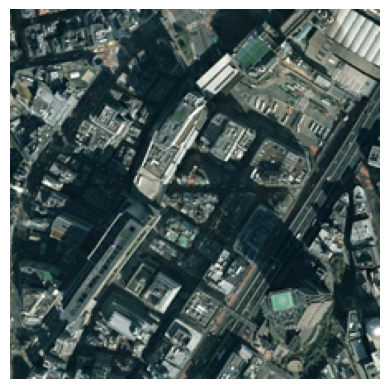

['Many overcrowded buildings are located in a commercial area.'
 'Many buildings full of people are located in a commercial area.'
 'Many crowded buildings are in a commercial area.'
 'Many crowded buildings are in a commercial area.'
 'many crowded buildings are in a commercial area .']


In [ ]:
def show_img(dataset, idx): #function to clean and display an image and its caption
    s = dataset["image"][idx]
    data = ast.literal_eval(s) #in csv the data is stored as a string, so we convert it back to dictionary
    b = data["bytes"] #data is a dict 
    img = tf.image.decode_jpeg(b) #decoding the jpeg image
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    print(dataset["captions"][idx])
show_img(train_df, 1856)

## 1.2. Image Dimensions and Number of captions for each image

In [ ]:
def regex_captions(text): #function to count the number of special tokens in a caption to find the number of captions for each image
        newlines = re.findall(r'\n', text)
        spaces = re.findall(r"' '", text)
        stray_quotes = re.findall(r'\\\'', text)
        return len(newlines) + len(spaces) + len(stray_quotes) + 1

In [ ]:
non_compliant = [[[], [], []], [[], [], []]] # to store indices of non-compliant images and captions in train, test and validation sets
for j, df in [[0, train_df], [1, test_df], [2,valid_df]] :
  for i in range (len(df)):
      s = df["image"][i]
      data = ast.literal_eval(s) #in csv the data is stored as a string, so we convert it back to dictionary
      b = data["bytes"]
      img = Image.open(io.BytesIO(b))
      if (np.shape(img) != (224, 224, 3)): #shape mismatch
        non_compliant[0][j].append(i)
      if (regex_captions(df["captions"][i]) != 5): #numebr of captions not equal to 5
        non_compliant[1][j].append(i)
print("All images are of the specified dimensions") if non_compliant[0] == [[], [], []] else print(non_compliant[0])
print("All images have 5 captions") if non_compliant[1] == [[], [], []] else print(f" Train: {len(non_compliant[1][0])} \n Test: {len(non_compliant[1][1])} \n Validation: {len(non_compliant[1][2])}")

All images are of the specified dimensions
 Train: 386 
 Test: 12 
 Validation: 65


## 1.3. Train - Test - Validation Split
- Desired = 8000 : 1421 : 1500

In [69]:
print(f"Train : Test : Validation :: {len(train_df)} : {len(test_df)} : {len(valid_df)}")

Train : Test : Validation :: 8734 : 1093 : 1094


- Correcting the split

In [ ]:
# Here, I played around with the seed values to get the split with the best setence tokenizer accuracy
len_total = len(train_df) + len(test_df) + len(valid_df)
train_df_new, temp = train_test_split(pd.concat([train_df, test_df, valid_df], ignore_index = True), train_size = 8000/(len_total), shuffle = True, random_state = 0)
test_df_new, valid_df_new = train_test_split(temp, train_size = 1421/(len_total - 8000),  shuffle = True, random_state = 0)

train_df_new = train_df_new.reset_index(drop=True)
test_df_new = test_df_new.reset_index(drop=True)
valid_df_new = valid_df_new.reset_index(drop=True)

In [71]:
print(f"Train : Test : Validation :: {len(train_df_new)} : {len(test_df_new)} : {len(valid_df_new)}")

Train : Test : Validation :: 8000 : 1421 : 1500


## 1.4. Caption cleaning and Tokenization

- The captions in the dataset are unorganized with stray brackets and apostrophes
- I am using sentence tokenization for "cleaning" these and organizing them into lists of 5 strings each.
- Comparing "rule based" and learned sentence tokenization

In [ ]:
class sent_tokenizers: #class to implement and compare punkt sentence tokenizer and a rule based sentence tokenizer
  def __init__(self, training_df):
    self.training_df = training_df

  def punkt_sent_tokenize_train(self): #function to train and return a punkt sentence tokenizer - learnt
    training_text = ""
    for caption in self.training_df["captions"]: #combine all captions in the training set to form a large training text
        training_text += caption.strip("[]'\"").replace("'", " ")

        # Train tokenizer
        trainer = PunktTrainer()
        trainer.INCLUDE_ALL_COLLOCS = True   # optional, improves abbreviation detection
        trainer.train(training_text)

        # Build tokenizer from trainer
        tokenizer = PunktSentenceTokenizer(trainer.get_params())
        return tokenizer

  def regex_sentence_tokenize(self, text): # rule based sentence tokenizer
      sentences = re.split(r'\n+', text.strip("[]").replace("'", " "))
      sentences = [s.strip() for s in sentences if s.strip()]
      return sentences

tokenizers_inst = sent_tokenizers(train_df_new)
punk_tokenizer = tokenizers_inst.punkt_sent_tokenize_train() #trained punkt tokenizer


wrong_len = {"train": [[], []], "test": [[], []], "valid": [[], []]}
for idx in range(len(train_df_new)):
    caption = train_df_new["captions"][idx]

    tokenized = punk_tokenizer.tokenize(caption.strip("[]'\"").replace("'", " "))
    tokenized_regex = tokenizers_inst.regex_sentence_tokenize(caption.strip("[]'\"").replace("'", " "))
    train_df_new.loc[idx, "captions"] = tokenized #ADDED AFTER EXPERIMENTING

    wrong_len["train"][0].append(idx) if len(tokenized) != 5 else 0 #wrong number of captions - punkt
    wrong_len["train"][1].append(idx) if len(tokenized_regex) != 5 else 0 #wrong number of captions - regex

    if(idx < len(test_df_new)):
       caption = test_df_new["captions"][idx]
       tokenized = punk_tokenizer.tokenize(caption.strip("[]'\"").replace("'", " "))
       tokenized_regex = tokenizers_inst.regex_sentence_tokenize(caption.strip("[]'\"").replace("'", " "))
       test_df_new.loc[idx, "captions"] = tokenized #ADDED AFTER EXPERIMENTING

       wrong_len["test"][0].append(idx) if len(tokenized) != 5 else 0 #wrong number of captions - punkt
       wrong_len["test"][1].append(idx) if len(tokenized_regex) != 5 else 0 #wrong number of captions - regex

    if(idx < len(valid_df_new)):
       caption = valid_df_new["captions"][idx]
       tokenized = punk_tokenizer.tokenize(caption.strip("[]'\"").replace("'", " "))
       tokenized_regex = tokenizers_inst.regex_sentence_tokenize(caption.strip("[]'\"").replace("'", " "))
       valid_df_new.loc[idx, "captions"] = tokenized #ADDED AFTER EXPERIMENTING

       wrong_len["valid"][0].append(idx) if len(tokenized) != 5 else 0 #wrong number of captions - punkt
       wrong_len["valid"][1].append(idx) if len(tokenized_regex) != 5 else 0 #wrong number of captions - regex

print(f"Punkt Sentence tokenizer accuracy: \n Train: {1 - (len(wrong_len['train'][0])/len(train_df_new))} \n Test: {1 - (len(wrong_len['test'][0])/len(test_df_new))} \n Validation: {1 - (len(wrong_len['valid'][0])/len(valid_df_new))}")
print(f"\nRule based Sentence tokenizer accuracy: \n Train: {1 - (len(wrong_len['train'][1])/len(train_df_new))} \n Test: {1 - (len(wrong_len['test'][1])/len(test_df_new))} \n Validation: {1 - len(wrong_len['valid'][1])/len(valid_df_new)}")

Punkt Sentence tokenizer accuracy: 
 Train: 0.998625 
 Test: 0.9985925404644617 
 Validation: 0.9993333333333333

Rule based Sentence tokenizer accuracy: 
 Train: 0.9055 
 Test: 0.9085151301900071 
 Validation: 0.9153333333333333


- Going with Punkt sentence tokenizer and dropping the "dirty" entries

In [73]:
train_df_new = train_df_new.drop(wrong_len["train"][0]).reset_index(drop = True)
test_df_new = test_df_new.drop(wrong_len["test"][0]).reset_index(drop = True)
valid_df_new = valid_df_new.drop(wrong_len["valid"][0]).reset_index(drop = True)

In [74]:
print(f"Train : Test : Validation :: {len(train_df_new)} : {len(test_df_new)} : {len(valid_df_new)}")

Train : Test : Validation :: 7989 : 1419 : 1499


## 1.5. Word-level tokenization
- Constructing a word-level vocab based only on the training data (to avoid leakage of test/validation data into the training)
- Using this to train a word tokenizer

- Constructing the training captions

In [51]:
training_captions = []
for caption_list in train_df_new["captions"]:
    training_captions += caption_list

- Tokenizing the captions and storing them in a new column in the dfs

ChatGPT code (Had issues - highlighted in LLM debugging)
``` ---- Step 1: Build tokenizer on *train only* ----
vocab_size = 10000  # ~10k
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<unk>")
tokenizer.fit_on_texts(train_captions)

# Add special tokens manually
tokenizer.word_index["<pad>"] = 0  # Ensure pad=0
tokenizer.word_index["<bos>"] = len(tokenizer.word_index) + 1
tokenizer.word_index["<eos>"] = len(tokenizer.word_index) + 1
tokenizer.index_word = {v: k for k, v in tokenizer.word_index.items()}```

In [ ]:
class word_tokenizer:
  def __init__(self, training_list):
    self.training_list = training_list
    self.tokenizer = self.train_word_tokenizer()

  def train_word_tokenizer(self):
    # ---- Step 1: Build tokenizer on *train only* ----
    vocab_size = 10000  # ~10k
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<unk>")
    tokenizer.fit_on_texts(self.training_list)

    # Add special tokens manually
    tokenizer.word_index["<pad>"] = 0  # Ensure pad=0
    tokenizer.word_index["<bos>"] = len(tokenizer.word_index) #bos - MADE CORRECTION HERE
    tokenizer.word_index["<eos>"] = len(tokenizer.word_index) #Eos - MADE CORRECTION HERE
    tokenizer.index_word = {v: k for k, v in tokenizer.word_index.items()} #reverse dictionary

    return tokenizer

  def preprocess_captions(self, captions, max_len=26):
      seqs = []
      for cap in captions:
          tokens = self.tokenizer.texts_to_sequences([cap])[0] # list of token ids
          tokens = [self.tokenizer.word_index["<bos>"]] + tokens + [self.tokenizer.word_index["<eos>"]] # add bos/eos
          seqs.append(tokens)

      # pad sequences
      seqs = pad_sequences(seqs, maxlen=max_len, padding='post', truncating='post', value=self.tokenizer.word_index["<pad>"]) #pad with 0 for consisitent tensor shape
      return seqs

# ---- Step 3: Apply ----
word_tokenizer_inst = word_tokenizer(training_captions)
token_dict = word_tokenizer_inst.tokenizer.index_word
inverted_token_dict = {v: k for k, v in token_dict.items()} #reverse dictionary - to be used later during inference
#Adding a column of tokenized captions to the dataframes
for df in [train_df_new, test_df_new, valid_df_new]:
  captions_tokenized = []
  for caption in df["captions"]:
      captions_tokenized.append(word_tokenizer_inst.preprocess_captions(caption))
  df["captions_tokenized"] = captions_tokenized

## 1.6. Analyzing the tokenization across the datasets
- Vocab coverage & OOV%

In [ ]:
def find_OOV(df): #finding oov token % - one the whole set of tokens
    tokens_array = df["captions_tokenized"]
    num_oov = 0
    tot_tok = 0
    token_dict = word_tokenizer_inst.tokenizer.word_index
    length_array = [] #for length histogram
    for tokens_list in tokens_array:
        for tokens in tokens_list:
            ctr = 0
            for token in tokens:
                if(token == 1): # <unk> token
                   num_oov += 1
                elif(token > 0 and (token < len(token_dict) - 1)): #excluding <pad>, <bos> and <eos> tokens
                   tot_tok += 1
                elif(token == 0): #increase sentence count by 1
                   length_array.append(ctr)
                   break
                ctr += 1
    return 100*(num_oov/tot_tok), length_array

train_oov, train_length_array = find_OOV(train_df_new)
test_oov, test_length_array = find_OOV(test_df_new)
valid_oov, valid_length_array = find_OOV(valid_df_new)

print(f"Out of Vocab %:\n Train: {train_oov:.2f}%\n Test: {test_oov:.2f}%\n Validation: {valid_oov:.2f}%")

Out of Vocab %:
 Train: 0.00%
 Test: 0.32%
 Validation: 0.32%


- Length histogram

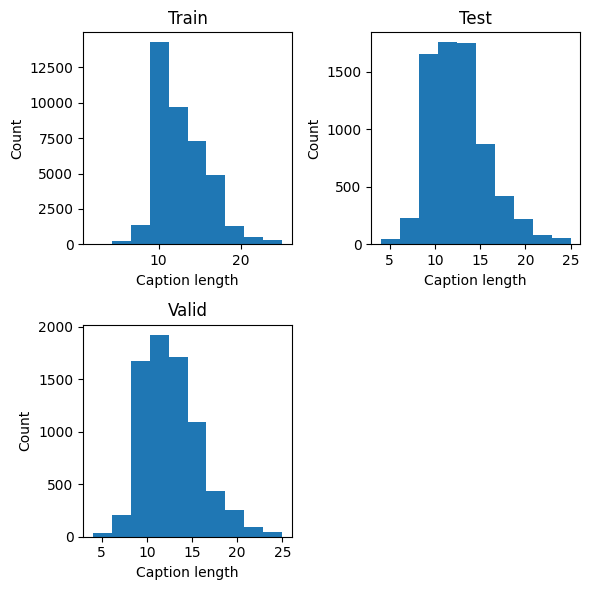

In [ ]:
import matplotlib.pyplot as plt

#entirely ChatGPT generated
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

axes[0, 0].hist(train_length_array) # Histogram for training df caption lengths
axes[0, 0].set_xlabel("Caption length")
axes[0, 0].set_ylabel("Count")
axes[0, 0].set_title("Train")

axes[0, 1].hist(test_length_array) # Histogram for test df caption lengths
axes[0, 1].set_xlabel("Caption length")
axes[0, 1].set_ylabel("Count")
axes[0, 1].set_title("Test")

axes[1, 0].hist(valid_length_array) # Histogram for validation df caption lengths
axes[1, 0].set_xlabel("Caption length")
axes[1, 0].set_ylabel("Count")
axes[1, 0].set_title("Valid")

fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.show()


## 1.7. Generating dense word embeddings
- Feeding the vocabulary and the word indices into the word2vec to generate the word embeddings
- dim_word_emb

- Creating a corpus - just all 40000 captions appended together

In [ ]:
w2v_training_corpus = [] #Creating a corpus - just all 40000 captions appended together
for caption_list in train_df_new["captions_tokenized"]:
    for caption in caption_list:
        for token in caption:
          if(token == 0):
             break
          w2v_training_corpus.append(token)

- Building Skip-Gram pairs
- NOTE: Keras has an implementation error and that makes giving seed input necessary even though it is optional

In [ ]:
vocab_size = 3030 #3028 = bos, 3029 = eos
window_size = 4

skip_grams, labels = skipgrams(
    w2v_training_corpus,
    vocabulary_size=vocab_size,
    window_size=window_size,
    negative_samples=1.0,  # ratio of negative to positive samples
    seed = 1856 # putting the seed due to an implementation error in keras
)

- Building the model

In [ ]:
embedding_dim = 512 # as specified in the problem statement

#targets and contexts for skip-gram
target_input = layers.Input(shape=(1,))
context_input = layers.Input(shape=(1,))

target_embedding = layers.Embedding(vocab_size, embedding_dim)(target_input)
context_embedding = layers.Embedding(vocab_size, embedding_dim)(context_input)

dot_product = layers.Dot(axes=-1)([target_embedding, context_embedding])
dot_product = layers.Reshape((1,))(dot_product)

output = layers.Dense(1, activation="sigmoid")(dot_product)

word2vec = tf.keras.Model([target_input, context_input], output)
word2vec.compile(optimizer="adam", loss="binary_crossentropy")

- Training the model

In [ ]:
targets, contexts = zip(*skip_grams) # unzip the skip-gram pairs
targets = np.array(targets, dtype="int32") # converting to numpy arrays
contexts = np.array(contexts, dtype="int32") 
labels = np.array(labels, dtype="int32")

word2vec.fit([targets, contexts], labels, batch_size=1024, epochs=5) 

Epoch 1/5


I0000 00:00:1757344388.168384     105 service.cc:148] XLA service 0x7989940079c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757344388.173316     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757344388.173336     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757344388.443549     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


  66/7946 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.6878

I0000 00:00:1757344388.941317     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7946/7946 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.2085
Epoch 2/5
7946/7946 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.1497
Epoch 3/5
7946/7946 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.1424
Epoch 4/5
7946/7946 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.1378
Epoch 5/5
7946/7946 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.1345


In [60]:
word2vec.save("word2vec_model.keras")

In [61]:
from tensorflow.keras.models import load_model
word2vec = load_model("/kaggle/input/word2vec/keras/default/1/word2vec_model.keras")

In [62]:
embeddings = word2vec.layers[2].get_weights()[0]  # target embedding matrix
np.save("/kaggle/working/embeddings", embeddings)

## 1.8. Image Normalization

- Cleaning the image column
- Looking at the format of the image

In [63]:
train_df_new["image"][0][0:100]

"{'bytes': b'\\xff\\xd8\\xff\\xe0\\x00\\x10JFIF\\x00\\x01\\x01\\x01\\x05\\xd8\\x05\\xd8\\x00\\x00\\xff\\xed\\x084Photosh"

- This is a dict in a string
- We need to extract the value in the dict and use tensorflow image decode to convert the representation to int instead of hex
- img[i] = (img[i] - mean)/std - Normalization
- computing mean and std on the whole dataset

In [ ]:
class save_clean_img: # cleans, normalizes and saves the images as tensors in a pickle file
    def __init__(self, df, filename, directory = "/content/drive/MyDrive/EE782/Assignment_1/"):
        self.df = df.copy()
        self.filename = directory + filename
        [self.mean, self.std] = self.compute_mean_std() # computing mean and std beforehand for normalization

    def clean_image(self, image_string): # just like we did in show_img function
        image_dict = ast.literal_eval(image_string)
        image_hex = image_dict["bytes"]
        image_int = tf.cast(tf.image.decode_jpeg(image_hex), tf.float32) # need float32 for normalization
        return image_int

    def compute_mean_std(self):
        mean = tf.zeros([3]) # to store mean for each channel
        var = tf.zeros([3]) # to store variance for each channel
        for idx in range(len(self.df)):
            image_string = self.df["image"][idx]
            image_int = self.clean_image(image_string)
            mean += tf.reduce_mean(image_int, axis=[0, 1])
            var += tf.math.reduce_variance(image_int, axis=[0, 1])
            if(image_int.shape != [224, 224, 3]):
                print(f"Dimension conflict at indes {idx}") # just a check
        mean /= len(self.df)
        var /= len(self.df)
        return [torch.from_numpy(mean.numpy()), torch.sqrt(torch.from_numpy(var.numpy()))]

    def norm_image(self, idx):
        image_string = self.df["image"][idx]
        image_int = self.clean_image(image_string)
        image_float_torch = torch.from_numpy(image_int.numpy()).permute(2, 0, 1) # Permute to C x H x W to get torch tensor
        image_float_torch = (image_float_torch - self.mean[:, None, None]) / self.std[:, None, None]
        return image_float_torch

    def save_cleaned_images(self):
        for idx in range(len(self.df)):
            image_int = self.norm_image(idx)
            self.df.at[idx, "image"] = image_int  # update the row with tensor
            print(idx) if idx % 500 == 0 else None # just a progress check
    
        # Save the entire DataFrame in one go
        with open(self.filename, "wb") as f:
            pickle.dump(self.df, f)

In [66]:
train_df_new = train_df_new.drop(columns = ["filename", "captions"])
test_df_new = test_df_new.drop(columns = ["filename", "captions"])
valid_df_new = valid_df_new.drop(columns = ["filename", "captions"])

In [ ]:
# saving the cleaned and normalized images for further tasks
save_csv_train = save_clean_img(train_df_new, "train_df_new.pkl", directory = "")
save_csv_train.save_cleaned_images()

save_csv_test = save_clean_img(test_df_new, "test_df_new.pkl", directory = "")
save_csv_test.save_cleaned_images()

save_csv_valid = save_clean_img(valid_df_new, "valid_df_new.pkl", directory = "")
save_csv_valid.save_cleaned_images()

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
0
500
1000
0
500
1000


# 2. Baselines Implemented


- Loading the pre-processed data - normalized images and captionized tokens

In [ ]:
# reloading the processed data
train_df_new = pd.read_pickle("/kaggle/input/dataset-clean/train_df_new.pkl")
test_df_new = pd.read_pickle("/kaggle/input/dataset-clean/test_df_new.pkl")
valid_df_new = pd.read_pickle("/kaggle/input/dataset-clean/valid_df_new.pkl")
test_df_new_unnorm = pd.read_pickle("/kaggle/input/test-data-unnorm/test_df_new_unnorm.pkl")

# reloading the embeddings and inverted token dictionary
embeddings = np.load("/kaggle/input/word-embeddings/embeddings.npy")
with open('/kaggle/input/inverted-token-dict-1/inverted_token_dict.pkl', 'rb') as f:
    inverted_token_dict = pickle.load(f)

## 2.1. CNN Encoder

In [ ]:
class ResNet18Encoder(nn.Module): # ResNet18 backbone
    def __init__(self, pretrained=True, mode="cache"):
        super().__init__()
        # Load pretrained ResNet-18
        resnet = models.resnet18(pretrained=pretrained)
        # Remove classifier head
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # Global avg pooling
        self.mode = mode # not useful - intermediate step
        # grad cam related
        self.feature_maps = None
        self.feature_grads = None
        self._register_hooks()

    def forward(self, x):
        x = self.features(x)          # CNN backbone
        x = self.avgpool(x)           # Global avg pooling
        x = torch.flatten(x, 1)       # Flatten (batch, 512)
        return x

    def _register_hooks(self):  # for grad-cam
        # Hook to capture feature maps
        def forward_hook(module, input, output):
            self.feature_maps = output.detach()

        # Hook to capture gradients of feature maps
        def backward_hook(module, grad_input, grad_output):
            self.feature_grads = grad_output[0].detach()

        # Register hooks on the last conv layer (layer4)
        last_conv_block = self.features[-1]  # Assuming correct index
        last_conv_block.register_forward_hook(forward_hook)  ########
        last_conv_block.register_backward_hook(backward_hook)  ########

    def get_gradcam(self, target_logit):  # for grad-cam
        """
        Compute Grad-CAM heatmap for the target logit.
        Args:
            target_logit: Scalar output (e.g., EOS logit or salient word's logit)
        Returns:
            heatmap: numpy array of shape [H, W], normalized [0,1]
        """
        # Backpropagate from target logit ########
        self.feature_grads = None  # Reset gradients
        target_logit.backward(retain_graph=True)

        # Ensure gradients are captured ########
        assert self.feature_maps is not None, "Feature maps not captured."
        assert self.feature_grads is not None, "Feature gradients not captured."

        # Global average pooling of gradients ########
        weights = self.feature_grads.mean(dim=(2,3), keepdim=True)  # [B, C, 1, 1]

        # Weighted combination of feature maps ########
        gradcam_map = (weights * self.feature_maps).sum(dim=1, keepdim=True)  # [B,1,H,W]
        gradcam_map = F.relu(gradcam_map)  # Remove negatives

        # Normalize and resize to 224x224 ########
        gradcam_map = F.interpolate(gradcam_map, size=(224,224), mode='bilinear', align_corners=False)
        heatmap = gradcam_map.squeeze().cpu().numpy()  # [224,224]

        # Normalize heatmap to [0,1] ########
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

        return heatmap
        
class MobileNetV2Encoder(nn.Module): # MobileNet backbone
    def __init__(self, pretrained=True, mode="cache"):
        super().__init__()
        # Load pretrained MobileNetV2
        mobilenet = models.mobilenet_v2(pretrained=pretrained)

        # Use feature extractor part only (remove classifier)
        self.features = mobilenet.features  # Output: [B, 1280, 7, 7]

        # Global average pooling to get [B, 1280]
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.project = nn.Linear(1280, 512) # need this as the output of mobilenet is 1280-dim and we want 512-dim features
        
        self.mode = mode

        # No need for fine-tuning logic in feature cache mode

    def forward(self, x):
        x = self.features(x)         # [B, 1280, 7, 7]
        x = self.avgpool(x)          # [B, 1280, 1, 1]
        x = torch.flatten(x, 1)      # [B, 1280]
        x = self.project(x)          # [B, 512]
        return x


# ---------------------------
# Feature-cache mode
# ---------------------------
def cache_features(dataset, encoder, save_dir="features", batch_size=32, device="cuda"):
    os.makedirs(save_dir, exist_ok=True)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False) # no shuffling to maintain order
    encoder.to(device).eval() # set to eval mode

    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images = images.to(device) # move to device
            feats = encoder(images)    # save features and labels for this batch
            torch.save({"features": feats.cpu(), "labels": labels},
                       os.path.join(save_dir, f"batch_{i}.pt"))
    print(f"Saved features in {save_dir}")

class MyImageDataset(Dataset): # custom dataset class - this was useful initially but then i normalized the data beforehand and now this class is not very useful 
    def __init__(self, df, embeddings, image_col="image", caption_col = "captions_tokenized"):
        self.df = df
        self.image_col = image_col
        self.caption_col = caption_col
        self.embeddings = embeddings
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get the tensor directly (already normalized and 224x224x3)
        img = self.df.iloc[idx][self.image_col]
        cap = self.df.iloc[idx][self.caption_col]
        
        return (img, cap)

In [146]:
dataset = MyImageDataset(train_df_new, embeddings)

- ResNet18 Encoder

In [ ]:
encoder_cache_resnet = ResNet18Encoder(mode="cache") # feature cache mode - resnet18 backbone
cache_features(dataset, encoder_cache_resnet, save_dir="features")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


- MobileNet Encoder

In [ ]:
encoder_cache_mobilenet = MobileNetV2Encoder(mode="cache") # feature cache mode - mobilenetv2 backbone
cache_features(dataset, encoder_cache_mobilenet, save_dir="features")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 2.2. LSTM Decoder

- Image feature dimensions: 512
- Dense word embedding dimensions: 512 

ChatGPT generated code had issues in the inference function as highlighted in LLM Debugging section
``` 
    generated_tokens = []
    for t in range(max_len):
        lstm_out, (h, c) = self.lstm(input_word, (h, c))  # [B,1,hidden_dim]
        logits = self.fc_out(lstm_out.squeeze(1))          # [B, vocab_size]
        pred_token = torch.argmax(logits, dim=-1)          # [B]
        generated_tokens.append(pred_token)

        # For next step, feed **embedding of predicted token** 
        # Here, if you have an embedding matrix, use it. 
        # For demonstration, we'll assume input_word remains zeros.
        input_word = torch.zeros(B, 1, self.input_dim, device=device) 
```

In [ ]:
class LSTMDecoder(nn.Module): # LSTM decoder
    def __init__(self, vocab_size=3030, embed_dim=512, hidden_dim=512, num_layers=2, pad_idx=0, w2v_embeddings=None):
        """
        Args:
            vocab_size: Number of words in vocabulary (including PAD, BOS, EOS)
            embed_dim: Dimension of word embeddings (Word2Vec dim)
            hidden_dim: LSTM hidden state size
            num_layers: Number of LSTM layers
            pad_idx: index of PAD token
            w2v_embeddings: pre-trained embedding matrix [vocab_size, embed_dim] (torch.Tensor)
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.pad_idx = pad_idx # to be ignored in loss computation
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx) 
        if w2v_embeddings is not None: # load pre-trained w2v embeddings that we trained earlier
            self.embedding.weight = nn.Parameter(w2v_embeddings)
            self.embedding.weight.requires_grad = False  # freeze pre-trained embeddings

        # LSTM
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )

        # Project LSTM hidden state to vocabulary
        self.fc_out = nn.Linear(hidden_dim, vocab_size) 

        # Project image features to initial hidden and cell states
        self.img2hidden = nn.Linear(embed_dim, hidden_dim)
        self.img2cell = nn.Linear(embed_dim, hidden_dim)
            
    def forward(self, img_feats, captions):
        """
        Args:
            img_feats: [B, embed_dim] CNN features
            captions: [B, T] word indices
        Returns:
            logits: [B, T, vocab_size]
        """
        B = img_feats.size(0) # batch size
        # Initialize LSTM states
        embedded = self.embedding(captions)  # [B, T, embed_dim] (T = caption length)
        h0 = torch.tanh(self.img2hidden(img_feats)).unsqueeze(0).repeat(self.num_layers, 1, 1) # [num_layers, B, hidden_dim]
        c0 = torch.tanh(self.img2cell(img_feats)).unsqueeze(0).repeat(self.num_layers, 1, 1) # [num_layers, B, hidden_dim]

        # LSTM forward
        lstm_out, _ = self.lstm(embedded, (h0, c0))  # [B, T, hidden_dim]

        # Project to vocab logits
        logits = self.fc_out(lstm_out)  # [B, T, vocab_size]
        return logits

    def generate_greedy(self, img_feats, max_len=26, bos_idx=3028):
        """
        Greedy caption generation
        Args:
            img_feats: [B, embed_dim]
        Returns:
            predicted_tokens: [B, max_len]
        """
        B = img_feats.size(0) # batch size
        device = img_feats.device
        # Initialize LSTM states
        h = torch.tanh(self.img2hidden(img_feats)).unsqueeze(0).repeat(self.num_layers, 1, 1)
        c = torch.tanh(self.img2cell(img_feats)).unsqueeze(0).repeat(self.num_layers, 1, 1)
            
        # Start with BOS token
        input_word = torch.full((B, 1), bos_idx, dtype=torch.long, device=device)
        generated_tokens = [input_word[-1]] # list of predicted tokens - append bos as the first token

        for t in range(max_len):
            embedded = self.embedding(input_word)  # [B, 1, embed_dim]         
            lstm_out, (h, c) = self.lstm(embedded, (h, c))  # [B,1,hidden_dim]
            logits = self.fc_out(lstm_out.squeeze(1))        # [B, vocab_size]
            pred_token = torch.argmax(logits, dim=-1)        # [B]
            generated_tokens.append(pred_token)
            if(pred_token == 3029): # if eos is predicted, stop early - avoid generating further tokens until max_len is reached
               break
            input_word = pred_token.unsqueeze(1)             # feed predicted token next
        
        pad_token = torch.full((B,), 0, dtype=torch.long, device=device)
        for i in range(len(generated_tokens), max_len):
            generated_tokens.append(pad_token)

        return torch.stack(generated_tokens, dim=1)  # [B, max_len]

# -----------------------
# Training loop
# -----------------------
def train_lstm_from_batches(
    model,
    batch_dir="features",
    num_epochs=10,
    lr=1e-3,
    pad_idx=0,
    device="cuda"
):
    """
    Train LSTM decoder using batch files:
        image features: [B, embed_dim]
        captions: [B, 5, T] (word indices)
    """
    model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

    batch_files = sorted([os.path.join(batch_dir, f) for f in os.listdir(batch_dir) if f.endswith(".pt")])

    for epoch in range(num_epochs):
        total_loss = 0
        for batch_file in batch_files:
            batch = torch.load(batch_file)
            img_feats = batch["features"].to(device)  # [B, embed_dim]
            captions = batch["labels"].to(device)     # [B, 5, T]

            B, num_captions, T = captions.shape

            # Flatten captions: [B*5, T]
            captions_flat = captions.view(B * num_captions, T)
            # Repeat image features: [B*5, embed_dim]
            img_feats_flat = img_feats.unsqueeze(1).repeat(1, num_captions, 1).view(B * num_captions, -1) # ding this as there are 5 captions per image
                
            captions_input = captions_flat[:, :-1]  
            target = captions_flat[:, 1:]  

            optimizer.zero_grad()
            logits = model(img_feats_flat, captions_input)  # teacher forcing
            target = captions_flat[:, 1:]                          # next tokens

            # reshape for cross entropy
            loss = criterion(logits.reshape(-1, logits.size(-1)),target.reshape(-1).long())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(batch_files):.4f}")

In [ ]:
# -----------------------
# Inference helper
# -----------------------
def print_caption(input_img, cnn_encoder, lstm_decoder, inverse_vocab_dict = inverted_token_dict, device="cuda"):
    cnn_encoder.to(device).eval()
    lstm_decoder.to(device).eval()
    with torch.no_grad():
        img = input_img.unsqueeze(0).to(device) # Add batch dimension: [1,3,H,W]
        feat = cnn_encoder(img)  # [1, embed_dim]
        caption_tokenized = lstm_decoder.generate_greedy(feat).squeeze(0)
    caption_txt = ""
    for caption_idx in caption_tokenized[1:]:
        if(int(caption_idx) == 3029): # break at eos
           break
        caption_txt += " " + (inverted_token_dict[int(caption_idx)]) # construct the caption string
    return caption_tokenized, caption_txt

def compute_bleu(df, cnn_encoder, decoder):
    avg_bleu = 0 
    for i in range(len(df)):
        caption_tokenized, caption_txt = print_caption(df['image'][i], cnn_encoder, decoder)
        target = []
        for cap_idx in range(5):
            sentence = ""
            for token in df['captions_tokenized'][i][cap_idx][1:]:
                if(token == 3029): # break at eos
                   break
                sentence += " " + inverted_token_dict[token]
                
            target.append(sentence)
        target = [target]
        preds = [caption_txt]
        bleu = BLEUScore(n_gram = 4) # compute 4-gram bleu 
        avg_bleu += bleu(preds, target) #averaging bleu over the entire dataset
    return avg_bleu/len(df)

def compute_meteor(df, cnn_encoder, decoder):
    avg_meteor = 0
    for i in range(len(df)):
        caption_tokenized, caption_txt = print_caption(df['image'][i], cnn_encoder, decoder)
        max_meteor = 0
        for cap_idx in range(5):
            sentence = ""
            for token in df['captions_tokenized'][i][cap_idx][1:]:
                if(token == 3029): # stop at eos token
                   break
                sentence += " " + inverted_token_dict[token]
            score = single_meteor_score(sentence.split(), caption_txt.split())
            max_meteor = score if score > max_meteor else max_meteor # best meteor among the 5 reference captions
            
        avg_meteor += max_meteor # averaging the meteor score over the entire dataset
    return avg_meteor/len(df)

def token_stats(df, cnn_encoder, decoder): # average, std of caption length, % of degenerate repetitions
    caption_length_list = []
    deg_reps = 0
    for i in range(len(df)):
        caption_tokenized, caption_txt = print_caption(df['image'][i], cnn_encoder, decoder)
        caption_length = 0
        count_dict = defaultdict(int) #for counting and checking for >= 3 repetitions
        deg_rep = False # Make it true if degenerate repetition is encountered
        for token in caption_tokenized[1:]:
            if(token == 3029): #stop at eos
               break
            caption_length += 1
            count_dict[token] += 1 
            if(count_dict[token] == 3): #degenerate repetition encountered 
               deg_rep = True
        caption_length_list.append(caption_length)
        deg_reps += 1 if deg_rep else 0
        
    return [np.mean(caption_length_list), np.std(caption_length_list), 100*(deg_reps/len(df))]
        

## Training and Validation for different CNN Settings

- Resnet18 backbone
- Varying number of epochs between 50 and 100
- Observation: Overfitting was observed beyond 50 training epochs

In [ ]:
lstm_model_resnet = LSTMDecoder(w2v_embeddings = torch.tensor(embeddings)) # lstm, resnet backbone
train_lstm_from_batches(lstm_model_resnet, batch_dir = "/kaggle/input/cached-features", num_epochs =50)

Epoch 1/50, Loss: 3.8705
Epoch 2/50, Loss: 2.3627
Epoch 3/50, Loss: 1.9758
Epoch 4/50, Loss: 1.7935
Epoch 5/50, Loss: 1.6744
Epoch 6/50, Loss: 1.5825
Epoch 7/50, Loss: 1.5071
Epoch 8/50, Loss: 1.4426
Epoch 9/50, Loss: 1.3857
Epoch 10/50, Loss: 1.3333
Epoch 11/50, Loss: 1.2863
Epoch 12/50, Loss: 1.2430
Epoch 13/50, Loss: 1.2029
Epoch 14/50, Loss: 1.1650
Epoch 15/50, Loss: 1.1270
Epoch 16/50, Loss: 1.0878
Epoch 17/50, Loss: 1.0489
Epoch 18/50, Loss: 1.0118
Epoch 19/50, Loss: 0.9790
Epoch 20/50, Loss: 0.9451
Epoch 21/50, Loss: 0.9161
Epoch 22/50, Loss: 0.8873
Epoch 23/50, Loss: 0.8573
Epoch 24/50, Loss: 0.8280
Epoch 25/50, Loss: 0.8010
Epoch 26/50, Loss: 0.7764
Epoch 27/50, Loss: 0.7573
Epoch 28/50, Loss: 0.7353
Epoch 29/50, Loss: 0.7085
Epoch 30/50, Loss: 0.6800
Epoch 31/50, Loss: 0.6494
Epoch 32/50, Loss: 0.6236
Epoch 33/50, Loss: 0.5991
Epoch 34/50, Loss: 0.5771
Epoch 35/50, Loss: 0.5544
Epoch 36/50, Loss: 0.5357
Epoch 37/50, Loss: 0.5173
Epoch 38/50, Loss: 0.4991
Epoch 39/50, Loss: 0.

In [ ]:
torch.save(lstm_model_resnet.state_dict(), "lstm_decoder.pth")

In [ ]:
lstm_model_resnet = LSTMDecoder(w2v_embeddings = torch.tensor(embeddings))
lstm_model_resnet.load_state_dict(torch.load('/kaggle/input/lstm_decoder/pytorch/default/1/lstm_decoder.pth'))
lstm_model_resnet.eval() #load and set model in eval mode

LSTMDecoder(
  (embedding): Embedding(3030, 512, padding_idx=0)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True)
  (fc_out): Linear(in_features=512, out_features=3030, bias=True)
  (img2hidden): Linear(in_features=512, out_features=512, bias=True)
  (img2cell): Linear(in_features=512, out_features=512, bias=True)
)

In [14]:
print(f"BLEU Score \nTrain: {compute_bleu(train_df_new, encoder_cache_resnet, lstm_model_resnet)}, \nValid: {compute_bleu(valid_df_new, encoder_cache_resnet, lstm_model_resnet)}")

BLEU Score 
Train: 0.400983601808548, 
Valid: 0.19178742170333862


In [15]:
print(f"METEOR Score \nTrain: {compute_meteor(train_df_new, encoder_cache_resnet, lstm_model_resnet)}, \nValid: {compute_meteor(valid_df_new, encoder_cache_resnet, lstm_model_resnet)}")

METEOR Score 
Train: 0.6282883825048394, 
Valid: 0.4728349665998352


In [16]:
token_len_deg_rep = token_stats(valid_df_new, encoder_cache_resnet, lstm_model_resnet)
print(f"Caption stats (On Validation Data): \nAverage caption length, std_dev = {token_len_deg_rep[0]:.2f}, {token_len_deg_rep[1]:.2f} \nDegenerate Repetitions = {token_len_deg_rep[2]:.2f}")

Caption stats (On Validation Data): 
Average caption length, std_dev = 10.52, 2.80 
Degenerate Repetitions = 0.00


- MobileNet backbone

In [13]:
lstm_model_mobilenet = LSTMDecoder(w2v_embeddings = torch.tensor(embeddings))
train_lstm_from_batches(lstm_model_mobilenet, batch_dir = "/kaggle/input/cache-features-mobilenet/", num_epochs =50)

Epoch 1/50, Loss: 4.0719
Epoch 2/50, Loss: 2.5046
Epoch 3/50, Loss: 2.0290
Epoch 4/50, Loss: 1.8221
Epoch 5/50, Loss: 1.6923
Epoch 6/50, Loss: 1.5951
Epoch 7/50, Loss: 1.5141
Epoch 8/50, Loss: 1.4424
Epoch 9/50, Loss: 1.3765
Epoch 10/50, Loss: 1.3143
Epoch 11/50, Loss: 1.2538
Epoch 12/50, Loss: 1.1952
Epoch 13/50, Loss: 1.1391
Epoch 14/50, Loss: 1.0870
Epoch 15/50, Loss: 1.0380
Epoch 16/50, Loss: 0.9893
Epoch 17/50, Loss: 0.9430
Epoch 18/50, Loss: 0.9000
Epoch 19/50, Loss: 0.8582
Epoch 20/50, Loss: 0.8178
Epoch 21/50, Loss: 0.7724
Epoch 22/50, Loss: 0.7310
Epoch 23/50, Loss: 0.6912
Epoch 24/50, Loss: 0.6586
Epoch 25/50, Loss: 0.6325
Epoch 26/50, Loss: 0.6035
Epoch 27/50, Loss: 0.5697
Epoch 28/50, Loss: 0.5377
Epoch 29/50, Loss: 0.5080
Epoch 30/50, Loss: 0.4819
Epoch 31/50, Loss: 0.4536
Epoch 32/50, Loss: 0.4307
Epoch 33/50, Loss: 0.4118
Epoch 34/50, Loss: 0.4011
Epoch 35/50, Loss: 0.3864
Epoch 36/50, Loss: 0.3667
Epoch 37/50, Loss: 0.3443
Epoch 38/50, Loss: 0.3226
Epoch 39/50, Loss: 0.

In [15]:
torch.save(lstm_model_mobilenet.state_dict(), "lstm_model_mobilenet.pth")

In [11]:
lstm_model_mobilenet = LSTMDecoder(w2v_embeddings = torch.tensor(embeddings))
lstm_model_mobilenet.load_state_dict(torch.load('/kaggle/input/lstm_decoder_mobilenet/pytorch/default/1/lstm_model_mobilenet_1.pth'))
lstm_model_mobilenet.eval()

LSTMDecoder(
  (embedding): Embedding(3030, 512, padding_idx=0)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True)
  (fc_out): Linear(in_features=512, out_features=3030, bias=True)
  (img2hidden): Linear(in_features=512, out_features=512, bias=True)
  (img2cell): Linear(in_features=512, out_features=512, bias=True)
)

In [18]:
print(f"BLEU Score \nTrain: {compute_bleu(train_df_new, encoder_cache_mobilenet, lstm_model_mobilenet)}, \nValid: {compute_bleu(valid_df_new, encoder_cache_mobilenet, lstm_model_mobilenet)}")

BLEU Score 
Train: 0.0013826227514073253, 
Valid: 0.000969289627391845


In [19]:
print(f"METEOR Score \nTrain: {compute_meteor(train_df_new, encoder_cache_mobilenet, lstm_model_mobilenet)}, \nValid: {compute_meteor(valid_df_new, encoder_cache_mobilenet, lstm_model_mobilenet)}")

METEOR Score 
Train: 0.03574769935599525, 
Valid: 0.03636392350884837


In [20]:
token_len_deg_rep = token_stats(valid_df_new, encoder_cache_mobilenet, lstm_model_mobilenet)
print(f"Caption stats (On Validation Data): \nAverage caption length, std_dev = {token_len_deg_rep[0]:.2f}, {token_len_deg_rep[1]:.2f} \nDegenerate Repetitions = {token_len_deg_rep[2]:.2f}")

Caption stats (On Validation Data): 
Average caption length, std_dev = 2.68, 2.18 
Degenerate Repetitions = 0.00


## Final Testing
- The ResNet18 Backbone seems more promising on the validation data as suggested by both - BLEU-4 and METEOR
- Using the ResNet Encoder - LSTM decoder for final evaluation

In [21]:
print(f"BLEU Score \nTest: {compute_bleu(test_df_new, encoder_cache_resnet, lstm_model_resnet)}")

BLEU Score 
Test: 0.1983533799648285


In [22]:
print(f"METEOR Score \nTest: {compute_meteor(test_df_new, encoder_cache_resnet, lstm_model_resnet)}")

METEOR Score 
Test: 0.48095151160982746


In [23]:
token_len_deg_rep = token_stats(test_df_new, encoder_cache_resnet, lstm_model_resnet)
print(f"Caption stats (On Test Data): \nAverage caption length, std_dev = {token_len_deg_rep[0]:.2f}, {token_len_deg_rep[1]:.2f} \nDegenerate Repetitions = {token_len_deg_rep[2]:.2f}")

Caption stats (On Test Data): 
Average caption length, std_dev = 10.64, 2.81 
Degenerate Repetitions = 0.00


# 2.3. Transformer Decoder

- 3 Layers
- 5 Attention heads
- d_model = 512
- Projected image feature to a single memory token with LayerNorm
- Standard causal mask + key padding mask
- Positional encoding length = 26
- Greedy decoding 
- Adam optimizer - learning rate 2e-4.

In [12]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size=3030, embed_dim=512, num_heads=4, num_layers=3, pad_idx=0, w2v_embeddings=None):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.pad_idx = pad_idx

        # Embedding layer with pre-trained word2vec embeddings
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        if w2v_embeddings is not None:
            self.embedding.weight = nn.Parameter(w2v_embeddings)
            self.embedding.weight.requires_grad = False  # freeze pre-trained embeddings

        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(1, 512, embed_dim))

        # Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Image feature to memory projection
        self.img2memory = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),  # project image to 2 tokens
            nn.LayerNorm(embed_dim * 2)
        )

        # Project output to vocabulary
        self.fc_out = nn.Linear(embed_dim, vocab_size)

    def forward(self, img_feats, captions):
        """
        img_feats: [B, embed_dim]
        captions: [B, T] word indices
        """
        B, T = captions.size()

        # Generate embeddings
        embedded = self.embedding(captions) + self.positional_encoding[:, :T, :]  # [B, T, embed_dim]

        # Project image features to memory tokens
        memory = self.img2memory(img_feats).view(B, 2, self.embed_dim)  # [B, 2, embed_dim]

        # Causal mask to prevent attending to future tokens
        causal_mask = torch.triu(torch.ones(T, T, device=img_feats.device) * float('-inf'), diagonal=1)

        # Key padding mask: pad_idx positions are True (masked)
        key_padding_mask = (captions == self.pad_idx)  # [B, T]

        output = self.transformer_decoder(
            tgt=embedded,
            memory=memory,
            tgt_mask=causal_mask,
            tgt_key_padding_mask=key_padding_mask
        )  # [B, T, embed_dim]

        logits = self.fc_out(output)  # [B, T, vocab_size]
        return logits

    def generate_greedy(self, img_feats, max_len=26, bos_idx=3028):
        B = img_feats.size(0)
        device = img_feats.device

        memory = self.img2memory(img_feats).view(B, 2, self.embed_dim)  # [B, 2, embed_dim]

        generated_tokens = [torch.full((B,), bos_idx, dtype=torch.long, device=device)]

        for t in range(max_len):
            captions_so_far = torch.stack(generated_tokens, dim=1)  # [B, t+1]
            embedded = self.embedding(captions_so_far) + self.positional_encoding[:, :t+1, :]

            causal_mask = torch.triu(torch.ones(t+1, t+1, device=device) * float('-inf'), diagonal=1)

            key_padding_mask = (captions_so_far == self.pad_idx)

            output = self.transformer_decoder(
                tgt=embedded,
                memory=memory,
                tgt_mask=causal_mask,
                tgt_key_padding_mask=key_padding_mask
            )  # [B, t+1, embed_dim]

            logits = self.fc_out(output[:, -1, :])  # [B, vocab_size]
            next_token = torch.argmax(logits, dim=-1)  # [B]

            generated_tokens.append(next_token)

            if torch.all(next_token == 3029):  # EOS token
                break

        # Pad if needed
        while len(generated_tokens) < max_len:
            generated_tokens.append(torch.full((B,), self.pad_idx, dtype=torch.long, device=device))

        return torch.stack(generated_tokens, dim=1)  # [B, max_len]

def train_transformer_from_batches(
    model,
    batch_dir="features",
    num_epochs=10,
    lr=2e-4,
    pad_idx=0,
    device="cuda"
):
    """
    Train Transformer decoder using batch files:
        image features: [B, embed_dim]
        captions: [B, 5, T] (word indices)
    """
    model.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

    batch_files = sorted([os.path.join(batch_dir, f) for f in os.listdir(batch_dir) if f.endswith(".pt")])

    for epoch in range(num_epochs):
        total_loss = 0
        for batch_file in batch_files:
            batch = torch.load(batch_file)
            img_feats = batch["features"].to(device)  # [B, embed_dim]
            captions = batch["labels"].to(device)     # [B, 5, T]

            B, num_captions, T = captions.shape

            # Flatten captions: [B*5, T]
            captions_flat = captions.view(B * num_captions, T)
            # Repeat image features: [B*5, embed_dim]
            img_feats_flat = img_feats.unsqueeze(1).repeat(1, num_captions, 1).view(B * num_captions, -1)

            captions_input = captions_flat[:, :-1]  # [B*5, T-1]
            target = captions_flat[:, 1:]          # [B*5, T-1]

            optimizer.zero_grad()
            logits = model(img_feats_flat, captions_input)  # teacher forcing

            loss = criterion(logits.reshape(-1, logits.size(-1)), target.reshape(-1).long())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(batch_files):.4f}")

## Training and Validation for different CNN Settings

- ResNet18 Backbone

In [93]:
transformer_model_resnet = TransformerDecoder(w2v_embeddings = torch.tensor(embeddings))
train_transformer_from_batches(transformer_model_resnet, batch_dir = "/kaggle/input/cached-features", num_epochs =25)

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1/25, Loss: 3.3066
Epoch 2/25, Loss: 2.1462
Epoch 3/25, Loss: 1.8892
Epoch 4/25, Loss: 1.7373
Epoch 5/25, Loss: 1.6208
Epoch 6/25, Loss: 1.5236
Epoch 7/25, Loss: 1.4369
Epoch 8/25, Loss: 1.3567
Epoch 9/25, Loss: 1.2804
Epoch 10/25, Loss: 1.2111
Epoch 11/25, Loss: 1.1413
Epoch 12/25, Loss: 1.0767
Epoch 13/25, Loss: 1.0158
Epoch 14/25, Loss: 0.9571
Epoch 15/25, Loss: 0.9010
Epoch 16/25, Loss: 0.8448
Epoch 17/25, Loss: 0.7950
Epoch 18/25, Loss: 0.7473
Epoch 19/25, Loss: 0.7055
Epoch 20/25, Loss: 0.6636
Epoch 21/25, Loss: 0.6269
Epoch 22/25, Loss: 0.5952
Epoch 23/25, Loss: 0.5633
Epoch 24/25, Loss: 0.5339
Epoch 25/25, Loss: 0.5077


In [94]:
torch.save(transformer_model_resnet.state_dict(), "transformer_model_resnet.pth")

In [13]:
transformer_model_resnet = TransformerDecoder(w2v_embeddings = torch.tensor(embeddings))
transformer_model_resnet.load_state_dict(torch.load('/kaggle/input/transformer_decoder/pytorch/default/1/transformer_model_resnet.pth'))
transformer_model_resnet.eval()

TransformerDecoder(
  (embedding): Embedding(3030, 512, padding_idx=0)
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
 

In [26]:
print(f"BLEU Score \nTrain: {compute_bleu(train_df_new, encoder_cache_resnet, transformer_model_resnet)}, \nValid: {compute_bleu(valid_df_new, encoder_cache_resnet, transformer_model_resnet)}")

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


BLEU Score 
Train: 0.6225103735923767, 
Valid: 0.22273947298526764


In [27]:
print(f"METEOR Score \nTrain: {compute_meteor(train_df_new, encoder_cache_resnet, transformer_model_resnet)} \nValid{compute_meteor(valid_df_new, encoder_cache_resnet, transformer_model_resnet)}")

METEOR Score 
Train: 0.7706823854578774 
Valid0.505456246109694


In [28]:
token_len_deg_rep = token_stats(valid_df_new, encoder_cache_resnet, transformer_model_resnet)
print(f"Caption stats (On Validation Data): \nAverage caption length, std_dev = {token_len_deg_rep[0]:.2f}, {token_len_deg_rep[1]:.2f} \nDegenerate Repetitions = {token_len_deg_rep[2]:.2f}")

Caption stats (On Validation Data): 
Average caption length, std_dev = 10.40, 2.87 
Degenerate Repetitions = 0.00


- MobileNet Backbone

In [117]:
transformer_model_mobilenet = TransformerDecoder(w2v_embeddings = torch.tensor(embeddings))
train_transformer_from_batches(transformer_model_mobilenet, batch_dir = "/kaggle/input/cache-features-mobilenet", num_epochs = 25)

Epoch 1/25, Loss: 3.2934
Epoch 2/25, Loss: 2.1390
Epoch 3/25, Loss: 1.8806
Epoch 4/25, Loss: 1.7265
Epoch 5/25, Loss: 1.6111
Epoch 6/25, Loss: 1.5124
Epoch 7/25, Loss: 1.4222
Epoch 8/25, Loss: 1.3406
Epoch 9/25, Loss: 1.2650
Epoch 10/25, Loss: 1.1912
Epoch 11/25, Loss: 1.1229
Epoch 12/25, Loss: 1.0525
Epoch 13/25, Loss: 0.9877
Epoch 14/25, Loss: 0.9248
Epoch 15/25, Loss: 0.8672
Epoch 16/25, Loss: 0.8114
Epoch 17/25, Loss: 0.7591
Epoch 18/25, Loss: 0.7130
Epoch 19/25, Loss: 0.6669
Epoch 20/25, Loss: 0.6263
Epoch 21/25, Loss: 0.5919
Epoch 22/25, Loss: 0.5597
Epoch 23/25, Loss: 0.5290
Epoch 24/25, Loss: 0.4990
Epoch 25/25, Loss: 0.4742


In [119]:
torch.save(transformer_model_mobilenet.state_dict(), "transformer_model_mobilenet.pth")

In [14]:
transformer_model_mobilenet = TransformerDecoder(w2v_embeddings = torch.tensor(embeddings))
transformer_model_mobilenet.load_state_dict(torch.load('/kaggle/input/transformer_decoder_mobilenet/pytorch/default/1/transformer_model_mobilenet.pth'))
transformer_model_mobilenet.eval()

TransformerDecoder(
  (embedding): Embedding(3030, 512, padding_idx=0)
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
 

In [30]:
print(f"BLEU Score \nTrain: {compute_bleu(train_df_new, encoder_cache_mobilenet, transformer_model_mobilenet)}, \nValid: {compute_bleu(valid_df_new, encoder_cache_mobilenet, transformer_model_mobilenet)}")

BLEU Score 
Train: 0.022852882742881775, 
Valid: 0.0227072574198246


In [31]:
print(f"METEOR Score \nTrain: {compute_meteor(train_df_new, encoder_cache_mobilenet, transformer_model_mobilenet)}, \nValid{compute_meteor(valid_df_new, encoder_cache_mobilenet, transformer_model_mobilenet)}")

METEOR Score 
Train: 0.21261862928958516, 
Valid0.20483197855529586


In [250]:
token_len_deg_rep = token_stats(valid_df_new, encoder_cache_mobilenet, transformer_model_mobilenet)
print(f"Caption stats (On Validation Data): \nAverage caption length, std_dev = {token_len_deg_rep[0]:.2f}, {token_len_deg_rep[1]:.2f} \nDegenerate Repetitions = {token_len_deg_rep[2]:.2f}")

Caption stats (On Validation Data): 
Average caption length, std_dev = 11.69, 2.40 
Degenerate Repetitions = 0.00


## Final Testing
- The ResNet18 Backbone seems more promising on the validation data as suggested by both - BLEU-4 and METEOR
- Using the ResNet Encoder - Transformer decoder for final evaluation

In [33]:
print(f"BLEU Score \nTest: {compute_bleu(test_df_new, encoder_cache_resnet, transformer_model_resnet)}")

BLEU Score 
Test: 0.24612979590892792


In [34]:
print(f"METEOR Score \nTest: {compute_meteor(test_df_new, encoder_cache_resnet, transformer_model_resnet)}")

METEOR Score 
Test: 0.5248980980480578


In [35]:
token_len_deg_rep = token_stats(test_df_new, encoder_cache_resnet, transformer_model_resnet)
print(f"Caption stats (On Test Data): \nAverage caption length, std_dev = {token_len_deg_rep[0]:.2f}, {token_len_deg_rep[1]:.2f} \nDegenerate Repetitions = {token_len_deg_rep[2]:.2f}")

Caption stats (On Test Data): 
Average caption length, std_dev = 10.47, 2.81 
Degenerate Repetitions = 0.00


# 3. LLM Debugging
- ChatGPT was the LLM used for writing the model classes and training functions

## 3.1. Appending special tokens in the vocab dict
- The code shown below leads to skipping of the last index in the tokenizer dict

![Token dict indices error](https://raw.githubusercontent.com/priyanshsingh1765/EE782-Autumn-2025/main/Images/error_token_dict.png)

- Correction

In [ ]:
tokenizer.word_index["<pad>"] = 0  # Ensure pad=0
tokenizer.word_index["<bos>"] = len(tokenizer.word_index)
tokenizer.word_index["<eos>"] = len(tokenizer.word_index)
tokenizer.index_word = {v: k for k, v in tokenizer.word_index.items()}

## 3.2. Batch Length Ignored
- The LSTM training function given by ChatGPT didn't account for the existence of 32 rows of data in each cached feature batch file
- This led to dimension mismatch errors
- I corrected this by adding a batch dimension to these variables

![Batch length error](https://raw.githubusercontent.com/priyanshsingh1765/EE782-Autumn-2025/main/Images/error_batch.png)

## 3.3. No BOS in Decoder inference
- Inference code written by ChatGPT didn't add the $<bos>$ token to the output sequence the way the output array was handled   

![No BOS error](https://raw.githubusercontent.com/priyanshsingh1765/EE782-Autumn-2025/main/Images/error_no_bos.png)

- Correction

In [ ]:
generated_tokens = [input_word[-1]]

for t in range(max_len):
    embedded = self.embedding(input_word)  # [B, 1, embed_dim]
    lstm_out, (h, c) = self.lstm(embedded, (h, c))  # [B,1,hidden_dim]
    logits = self.fc_out(lstm_out.squeeze(1))        # [B, vocab_size]
    pred_token = torch.argmax(logits, dim=-1)        # [B]
    generated_tokens.append(pred_token)
    if(pred_token == 3029):
       break
    input_word = pred_token.unsqueeze(1)             # feed predicted token next

## 3.4. No stopping criteria in decoder inference
- There was no stop applied on the decoder inference process even after reaching $<eos>$
- This led to continuous generation of $<eos>$ and garbage tokens until the max_len was reached

![No EOS stop](https://raw.githubusercontent.com/priyanshsingh1765/EE782-Autumn-2025/main/Images/error_no_eos_stop.png)

- Correction

In [ ]:
generated_tokens = [input_word[-1]]

for t in range(max_len):
    embedded = self.embedding(input_word)  # [B, 1, embed_dim]
    lstm_out, (h, c) = self.lstm(embedded, (h, c))  # [B,1,hidden_dim]
    logits = self.fc_out(lstm_out.squeeze(1))        # [B, vocab_size]
    pred_token = torch.argmax(logits, dim=-1)        # [B]
    generated_tokens.append(pred_token)
    if(pred_token == 3029):
       break
    input_word = pred_token.unsqueeze(1)             # feed predicted token next

# 4. Experimentation

## 4.1. Changing the CNN backbone (Performed during model validation)

$$
\begin{array}{|l|c|c|c|c|}
\hline
\textbf{Metric} & \textbf{ResNet-18 + LSTM} & \textbf{ResNet-18 + Transformer} & \textbf{MobileNet + LSTM} & \textbf{MobileNet + Transformer} \\
\hline
\text{BLEU-4} & 0.198 & 0.246 & 0.001 & 0.023 \\
\text{METEOR} & 0.481 & 0.525 & 0.036 & 0.205 \\
\hline
\end{array}
$$


## 4.2. Rotation Aware Augmentation

In [ ]:
def rotate_image(image_col, angle): # supports only 90 and 180 deg rotation
    result = []
    if angle == 90: 
        for image_tensor in image_col: 
            result.append(torch.flip(image_tensor.transpose(1, 2), dims=[1])) #rotate each image by 90deg and append to the result column
    elif angle == 180:
        for image_tensor in image_col:
            result.append(torch.flip(image_tensor, dims=[1, 2])) #rotate each image by 180deg and append to the result column
    return result
    
test_df_new_copy90 = test_df_new_copy180 = test_df_new.copy()
test_df_new_copy90["image"] = rotate_image(test_df_new['image'], 90)
test_df_new_copy180["image"] = rotate_image(test_df_new['image'], 180)

In [256]:
print(f"BLEU Score \nNo rotation: {compute_bleu(test_df_new, encoder_cache_resnet, transformer_model_resnet)}")
print(f"\n90deg rotation: {compute_bleu(test_df_new_copy90, encoder_cache_resnet, transformer_model_resnet)}")
print(f"\n180deg rotation: {compute_bleu(test_df_new_copy180, encoder_cache_resnet, transformer_model_resnet)}")

BLEU Score 
No rotation: 0.24612979590892792

90deg rotation: 0.23911508917808533

180deg rotation: 0.23911508917808533


In [257]:
print(f"METEOR Score \nNo rotation: {compute_meteor(test_df_new, encoder_cache_resnet, transformer_model_resnet)}")
print(f"\n90deg rotation: {compute_meteor(test_df_new_copy90, encoder_cache_resnet, transformer_model_resnet)}")
print(f"\n180deg rotation: {compute_meteor(test_df_new_copy180, encoder_cache_resnet, transformer_model_resnet)}")

METEOR Score 
No rotation: 0.5248980980480578

90deg rotation: 0.5104183486819964

180deg rotation: 0.5104183486819964


## Observations
- A very small reduction in the BLEU-4 and METEOR scores was observed on rotation of the input image by 180 and 90 degrees
- This reinforces the usability of these models for overhead image captioninig

# 5. Evaluation, Analysis and Explainability

## 5.1 Metrics

$$
\begin{array}{|l|c|c|c|c|}
\hline
\textbf{Metric} & \textbf{ResNet-18 + LSTM} & \textbf{ResNet-18 + Transformer} & \textbf{MobileNet + LSTM} & \textbf{MobileNet + Transformer} \\
\hline
\text{BLEU-4} & 0.198 & 0.246 & 0.001 & 0.023 \\
\text{METEOR} & 0.481 & 0.525 & 0.036 & 0.205 \\
\text{Avg Caption Length} & 10.64 & 10.47 & 2.68 & 11.69 \\
\text{Std Caption Length} & 2.81 & 2.81 & 2.18 & 2.4 \\
\text{\% Degenerate Repetitions} & 0 & 0 & 0 & 0 \\
\hline
\end{array}
$$


## 5.2 Qualitative and Slice Analysis

In [ ]:
def print_captions_orig(df, idx): #print captions given in the original dataset (Ground truth captions)
    all_captions = df["captions_tokenized"][idx]  # Should be a list of 5 caption lists
    captions = ""
    for i, caption_tokens in enumerate(all_captions):
        captions_str = inverted_token_dict.get(int(caption_tokens[1]), "<UNK>")
        for token in caption_tokens[2:]:
            if(token == 3029): # stop at eos
               break
            captions_str += " " + inverted_token_dict.get(int(token), "<UNK>")
        captions += captions_str + "\n"
    return captions # string containing 5 \n seperated string - 5 GT captions
    
def find_best_worst(df, cnn_encoder, decoder): #finds best and worst 10 generated captions in the test df
    meteor_dict = defaultdict(int)
    for i in range(len(df)):
        caption_tokenized, caption_txt = print_caption(df['image'][i], cnn_encoder, decoder) #inference
        max_meteor = 0
        for cap_idx in range(5):
            sentence = ""
            for token in df['captions_tokenized'][i][cap_idx][1:]:
                if(token == 3029): #stop at eos
                   break
                sentence += " " + inverted_token_dict[token]
            score = single_meteor_score(sentence.split(), caption_txt.split())
            max_meteor = score if score > max_meteor else max_meteor
            
        meteor_dict[max_meteor] = i
    meteor_list = np.sort(list(meteor_dict.keys())) #sort the list of meteor scores
    smallest_10 = [meteor_dict[ctr] for ctr in  meteor_list[:10]] # worst 10 generations 
    biggest_10 = [meteor_dict[ctr] for ctr in  meteor_list[-10:]] # best 10 generations
    return smallest_10, biggest_10

In [ ]:
worst_10, best_10 = find_best_worst(test_df_new, encoder_cache_resnet, transformer_model_resnet)
print(worst_10, best_10) #print results

([951, 704, 922, 982, 276, 509, 461, 1013, 103, 151],
 [309, 56, 1375, 1417, 1364, 1362, 1327, 1410, 1380, 1162])

In [ ]:
# Fully ChatGPT generated for showing an output window
def show_images_and_captions(unnorm_dataset, caption_dataset, indices): #3 columns 10 rows
    n_rows = len(indices)
    fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows * 5))

    for row_idx, idx in enumerate(indices):
        # Load image from unnormalized dataset
        s = unnorm_dataset["image"][idx]
        data = ast.literal_eval(s)
        b = data["bytes"]
        img = tf.image.decode_jpeg(b).numpy()

        # Column 1: Image
        axs[row_idx, 0].imshow(img)
        axs[row_idx, 0].axis("off")
        if row_idx == 0:
            axs[row_idx, 0].set_title("Image")
         
        # Column 2: Generated Caption
        caption = print_caption(caption_dataset['image'][idx], encoder_cache_resnet, transformer_model_resnet)[1]
        axs[row_idx, 1].text(0.5, 0.5, str(idx) + ".)" + caption, fontsize=10, wrap=True, ha='center', va='center')
        axs[row_idx, 1].axis("off")
        if row_idx == 0:
            axs[row_idx, 1].set_title("Generated Caption")

        # Column 3: Original Caption
        orig_caption = print_captions_orig(caption_dataset, idx)
        axs[row_idx, 2].text(0.5, 0.5, orig_caption, fontsize=10, wrap=True, ha='center', va='center')
        axs[row_idx, 2].axis("off")
        if row_idx == 0:
            axs[row_idx, 2].set_title("Original Caption")

    plt.tight_layout()
    plt.show()

- Worst 10 captioning (Test Data)

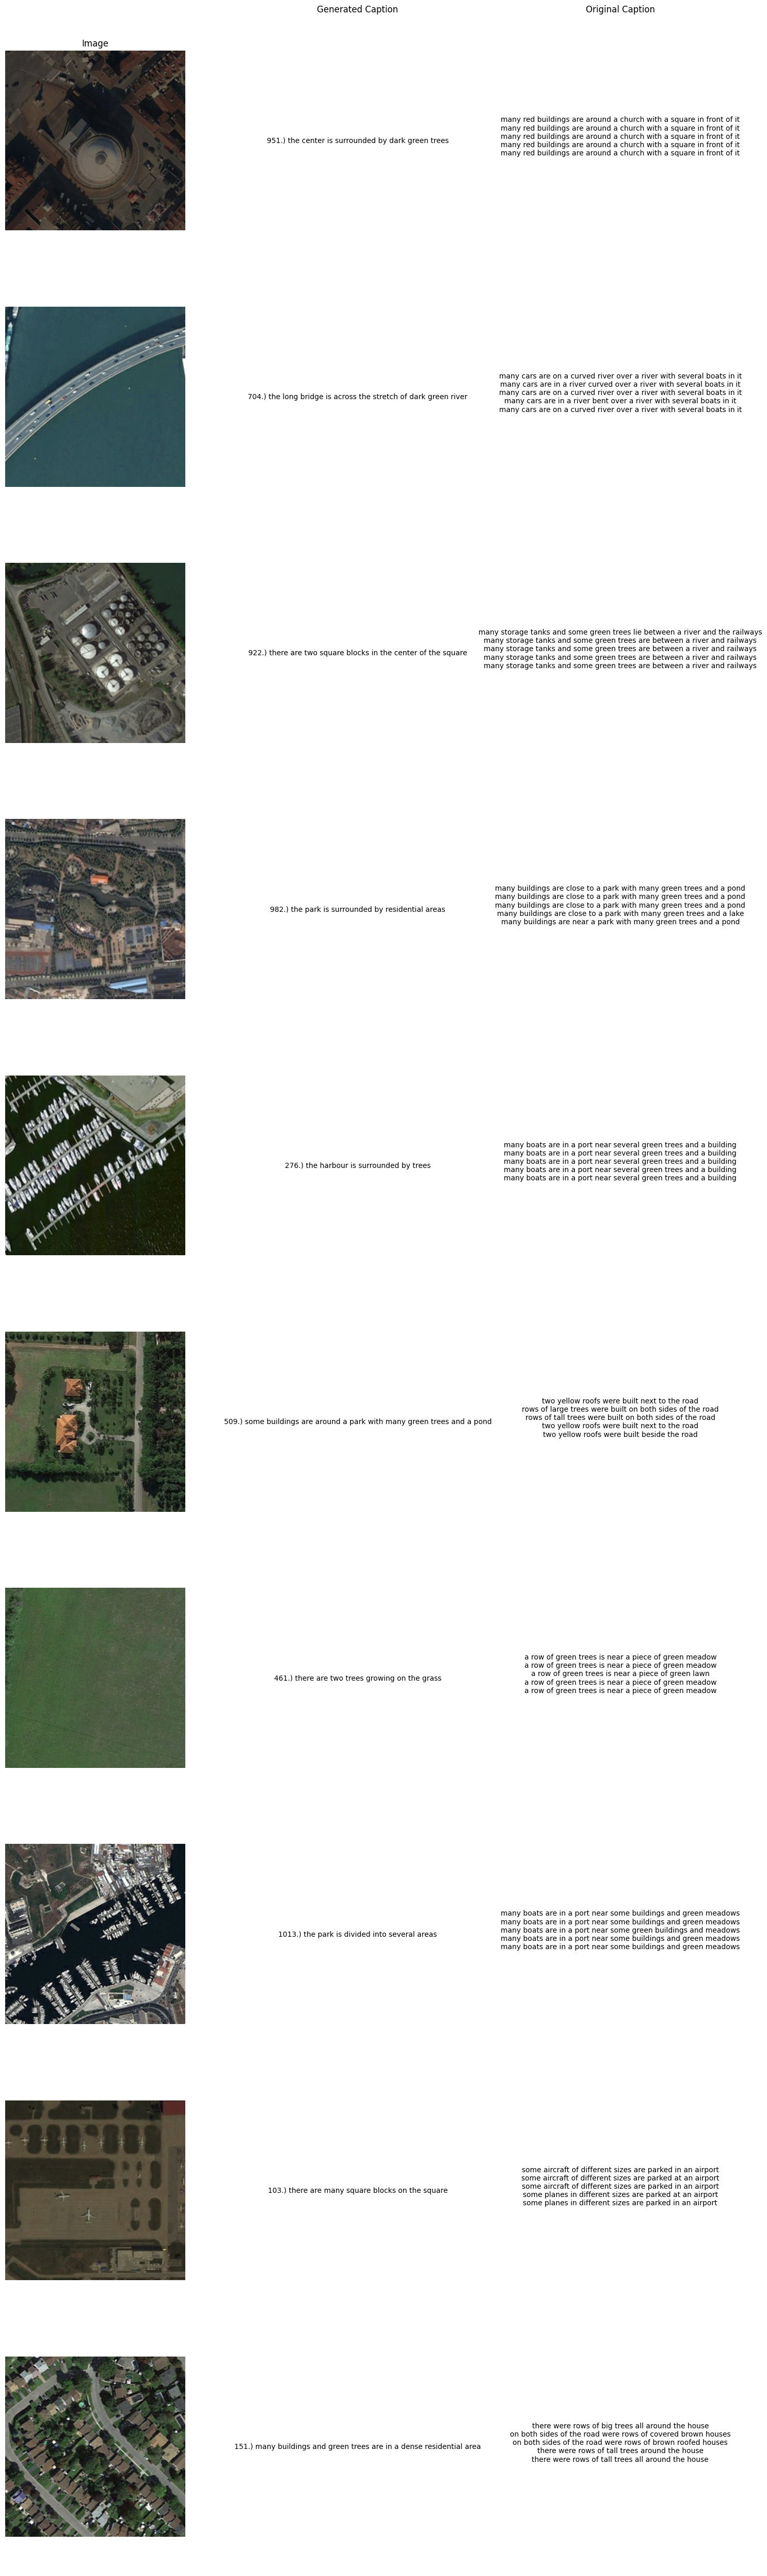

In [ ]:
all_indices = worst_10  # 10 indices total

show_images_and_captions(
    unnorm_dataset=test_df_new_unnorm,
    caption_dataset=test_df_new,
    indices=all_indices
)

- Best 10 captioning (Test Data)

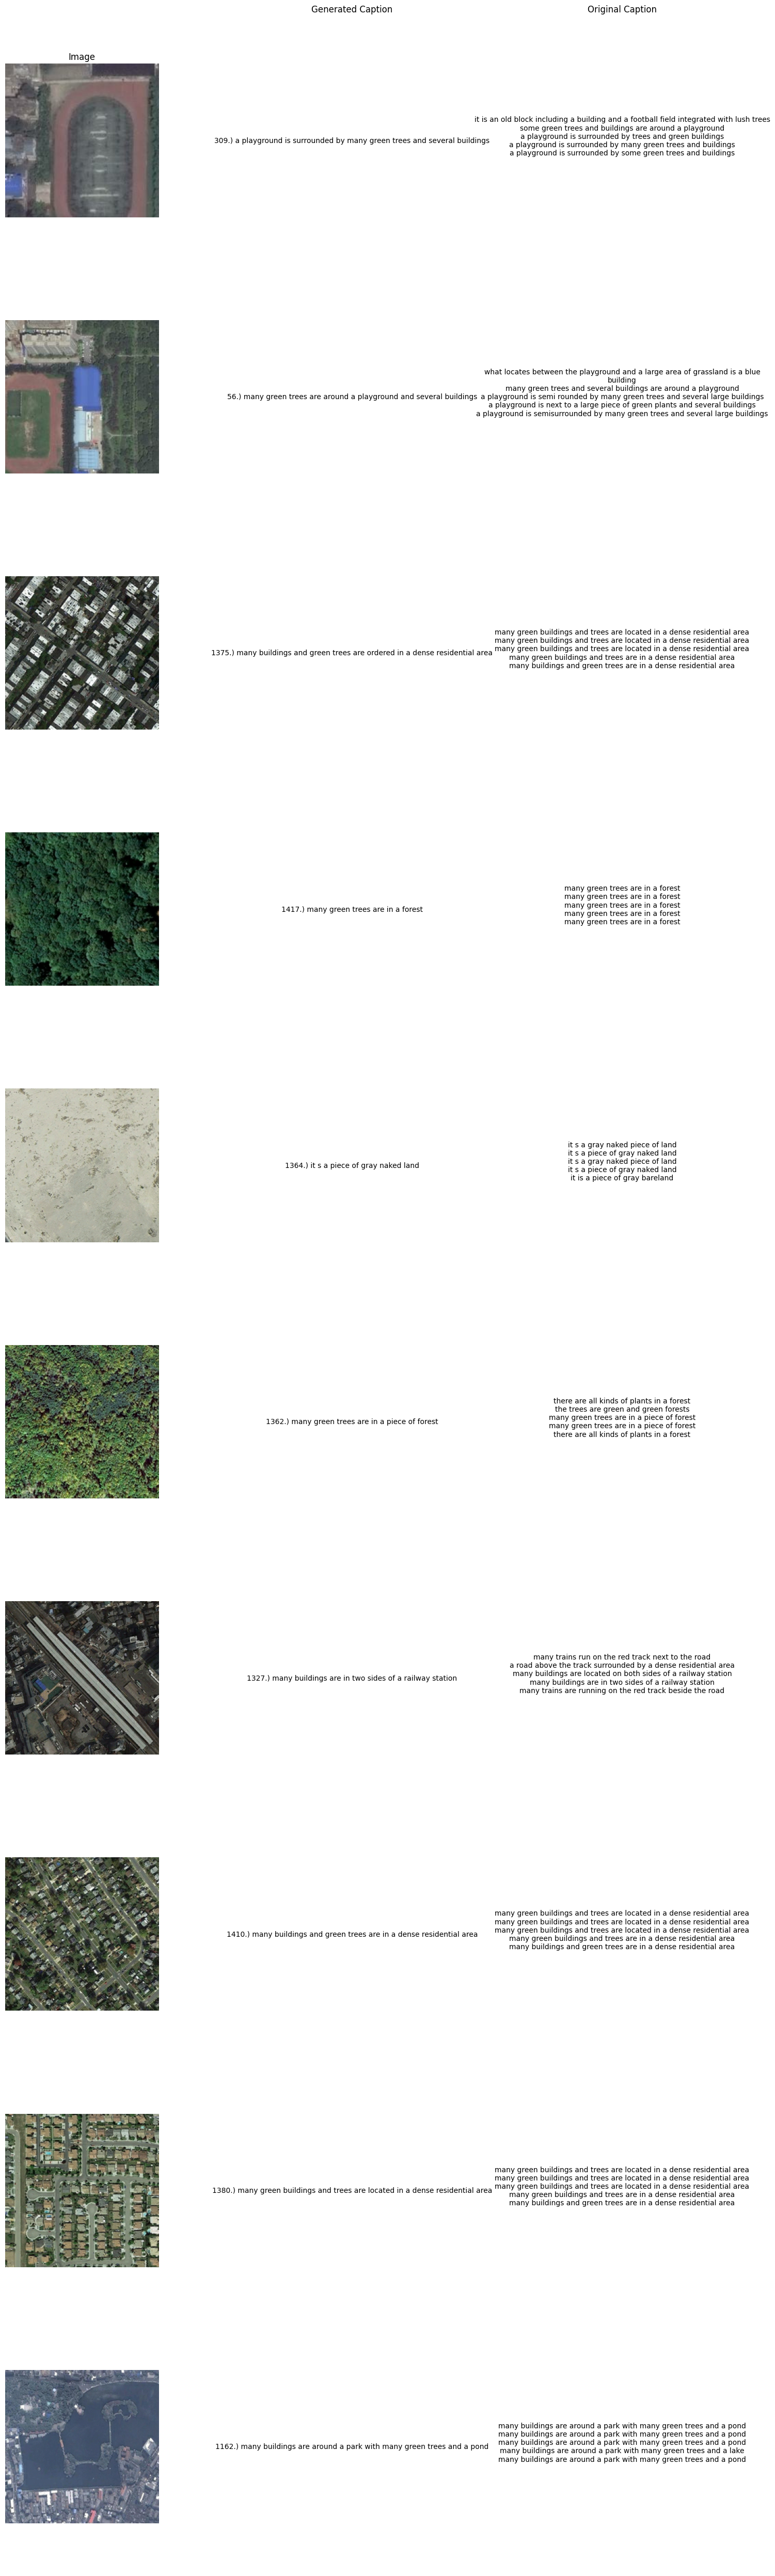

In [ ]:
all_indices = best_10  # 10 indices total

show_images_and_captions(
    unnorm_dataset=test_df_new_unnorm,
    caption_dataset=test_df_new,
    indices=all_indices
)

## 5.3 Explainability - GradCAM

In [ ]:
def show_gradcam_overlay(idx, token, df_norm = test_df_new, df_unnorm = test_df_new_unnorm, encoder = encoder_cache_resnet, decoder = transformer_model_resnet):
    token_dict = {v: k for k,v in inverted_token_dict.items()}  # invert token dict for lookup
    token_idx = token_dict[token]  # index of the target token
    row = test_df_new.iloc[idx]  
    encoder.to("cuda").eval()  # move encoder to cuda and set to eval mode
    img_tensor = row['image'].unsqueeze(0).to("cuda")  # Shape: [1,3,224,224], add batch dim
    feature_vector = encoder(img_tensor)    # [1, 512], extract image feature vector
    captions_input = torch.tensor(row['captions_tokenized'][0]).unsqueeze(0).to("cuda")  # tokenized caption input
    
    logits = decoder.forward(feature_vector, captions_input)  # [1, T, vocab_size], get vocab logits
    target_idx = token_idx  # target token index for gradcam
    target_token_position = 10 
    
    target_logit = logits[0, target_token_position, target_idx]  # extract scalar logit for Grad-CAM
    heatmap = encoder.get_gradcam(target_logit)  # [224, 224], gradcam heatmap in [0,1]
    
    s = df_unnorm["image"][idx]
    data = ast.literal_eval(s)  # same as we did in show_img
    b = data["bytes"]  
    image_np = tf.image.decode_jpeg(b).numpy()

    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)  
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)  

    overlayed_img = heatmap_color * 0.4 + image_np * 0.6  # blend heatmap and orig image
    overlayed_img = overlayed_img.astype(np.uint8)  # convert to uint8

    plt.figure(figsize=(10, 10))  # setup plot size
    plt.subplot(1, 3, 1)  # plot original image
    plt.imshow(image_np)  
    plt.title("Original Image")  
    plt.axis('off')

    plt.subplot(1, 3, 2)  # plot heatmap
    plt.imshow(heatmap, cmap='jet')  
    plt.title("Grad-CAM Heatmap")  
    plt.axis('off')

    plt.subplot(1, 3, 3)  # plot overlayed result
    plt.imshow(overlayed_img)  
    plt.title("Overlayed Image")  
    plt.axis('off')

    plt.show()  # display plots
    print(f"Generated caption: {print_caption(df_norm['image'][idx], encoder_cache_resnet, transformer_model_resnet)[1]}")  # print generated caption

- Good overlays

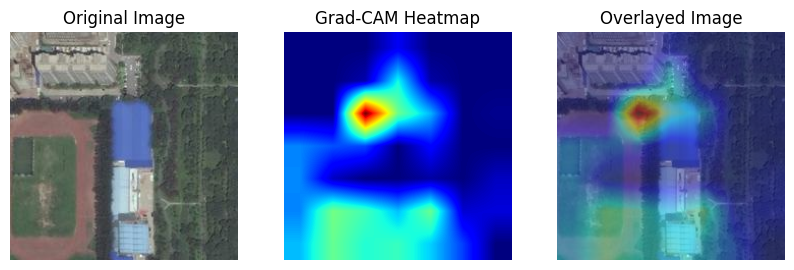

Generated caption:  many green trees are around a playground and several buildings


In [123]:
show_gradcam_overlay(56, 'playground')

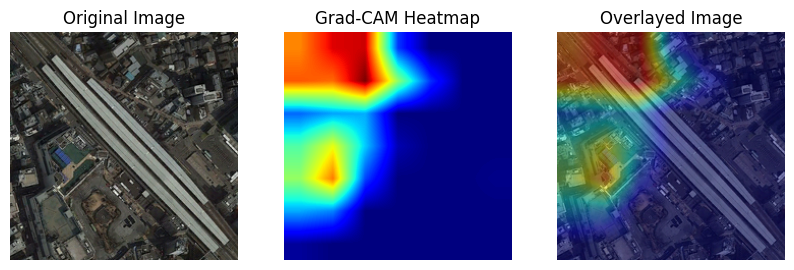

Generated caption:  many buildings are in two sides of a railway station


In [130]:
show_gradcam_overlay(1327, 'railway')

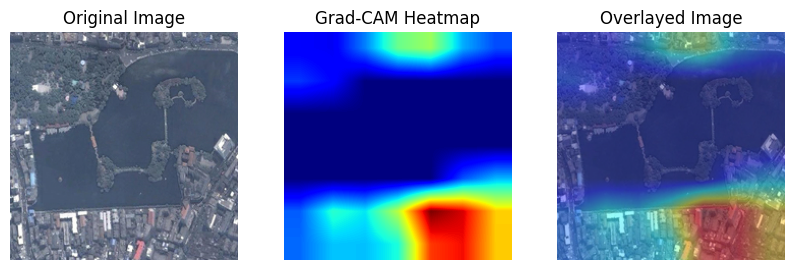

Generated caption:  many buildings are around a park with many green trees and a pond


In [134]:
show_gradcam_overlay(1162, 'buildings')

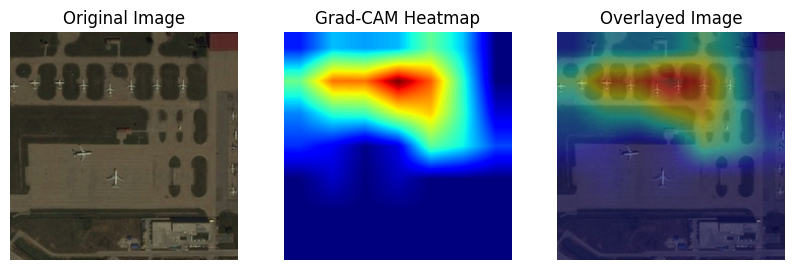

Generated caption:  there are many square blocks on the square


In [152]:
show_gradcam_overlay(103, 'blocks')

- Bad overlays

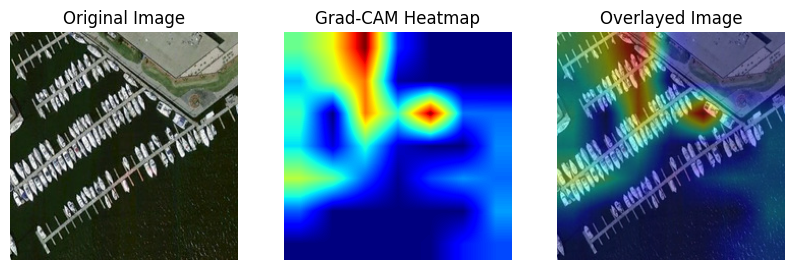

Generated caption:  the harbour is surrounded by trees


In [147]:
show_gradcam_overlay(276, 'trees')

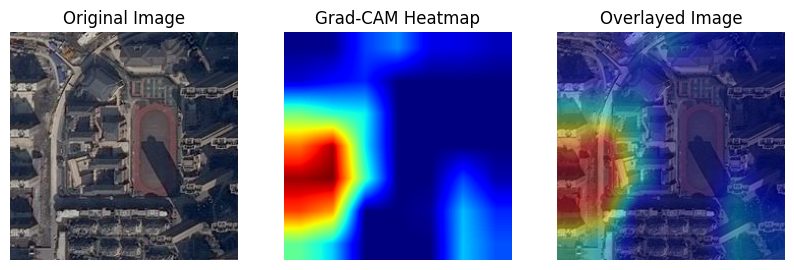

Generated caption:  many buildings are around a park with many green trees and a large pond


In [173]:
show_gradcam_overlay(47, 'pond')

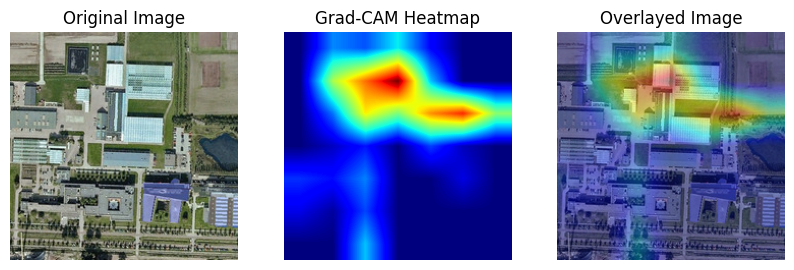

Generated caption:  many green buildings and trees are in a school


In [182]:
show_gradcam_overlay(921, 'trees')

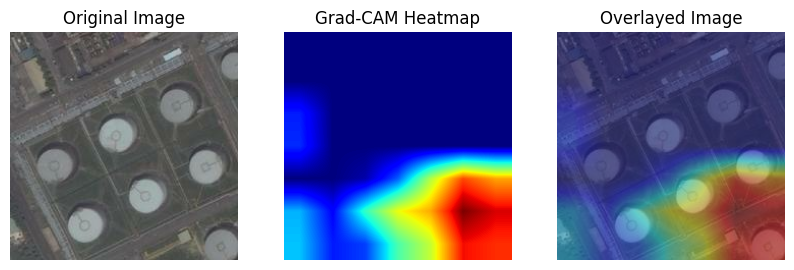

Generated caption:  two tanks are surrounded by some green trees


In [231]:
show_gradcam_overlay(1147, 'trees')